# Causal Inference with DoWhy: Motivation and Framework

## Why Causal Inference?

Most data science methods focus on answering questions of the form:

> *“What predicts the outcome?”*

These approaches are highly effective for prediction but insufficient when our goal is **decision-making** or **policy evaluation**. In many real-world settings, we are instead interested in questions such as:

- What happens to income **if** we increase education?
- Does a medical treatment **cause** better health outcomes?
- Will changing a recommendation algorithm **increase** user engagement?

These are **causal questions**, not predictive ones. They require reasoning about **interventions**—what would happen if we actively changed one variable while holding the rest of the system fixed.

A key challenge is that causal effects generally **cannot be inferred from correlations alone**. Observed associations may arise due to confounding or selection bias. As a result, causal inference requires:
- Explicit assumptions about how variables relate to each other
- A principled way to reason from those assumptions to estimable quantities
- Systematic checks of how robust conclusions are to violations of assumptions

---

## The DoWhy Philosophy

[**DoWhy**](https://www.pywhy.org/dowhy/v0.14/) is a Python library for causal inference that operationalizes Judea Pearl’s causal framework. Its central design principle is:

> **No causal estimation without explicit causal assumptions.**

Rather than treating causal inference as a single modeling step, DoWhy structures it as a **four-stage pipeline** that mirrors the scientific method.

---

## The 4-Step Causal Inference Pipeline

### 1. Model  
Specify the causal assumptions using a **causal graph** (Directed Acyclic Graph, DAG).  
The graph encodes domain knowledge about:
- Which variables cause which
- Which variables confound the treatment–outcome relationship
- Which variables are unobserved

This step is *conceptual*, not statistical.

---

### 2. Identify  
Using the causal graph, determine whether the causal effect of interest is **identifiable** from the observed data.

Identification answers the question:
> *Can the causal effect be expressed as a function of the observed variables, given the assumptions?*

This step relies on **do-calculus** and causal identification theory, not on numerical estimation.

---

### 3. Estimate  
Once an estimand is identified, compute its value using data and a chosen estimation method, such as:
- Linear regression
- Propensity score methods
- Inverse probability weighting
- Machine-learning–based estimators

Multiple estimators can be used for the same estimand.

---

### 4. Refute  
Evaluate the robustness of the causal estimate by attempting to **falsify** it.  
DoWhy provides automated refutation tests, including:
- Adding random confounders (random common cause)
- Placebo treatments
- Subsampling the data

Refutation does not prove correctness, but it helps assess how sensitive conclusions are to modeling assumptions.

---

# Step 0: Get the data

In [62]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# If you'd like to restore warnings later use the following line
# warnings.filterwarnings("default")
import pandas as pd
import numpy as np

# Simulate data following the causal graph
np.random.seed(42)
N = 10000
Z = np.random.normal(0, 1, N)  # common cause 
X = 80 * Z + np.random.normal(0, 1, N)  # treatment (dpending on the common cause)
Y = X + 30 * Z + np.random.normal(0, 1, N) # output (depending on the input and the common cause)

data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

# Step 1: Construct the graph! (Model)

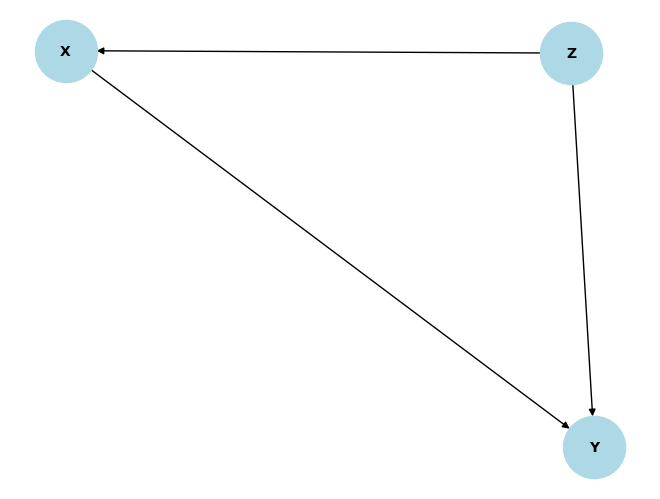

In [ ]:
import networkx as nx
from dowhy import CausalModel
import matplotlib.pyplot as plt

# Create a DAG using NetworkX
causal_graphNX = nx.DiGraph()

# Add nodes (variables)
#causal_graphNX.add_nodes_from(['X', 'Y', 'Z'])

# Add edges (causal effects)
#causal_graphNX.add_edges_from([('X', 'Y'), ('Z', 'X'), ('Z', 'Y')])

causal_graphNX = nx.DiGraph([('X', 'Y'), ('Z', 'X'), ('Z', 'Y')])

#causal_graphNX = nx.DiGraph([('X', 'Z')])

# Visualize the graph
nx.draw(causal_graphNX, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

# Step 2: Identify

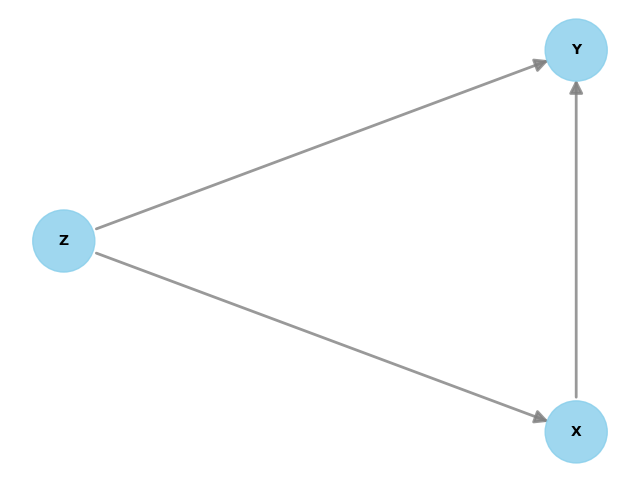

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Z])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z,U) = P(Y|X,Z)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [66]:
model = CausalModel(
    data=data,
    treatment='X',
    outcome='Y',
    graph=causal_graphNX
)

#model = CausalModel(
#    data=data,
#    treatment='X',
#    outcome='Y',
#    common_causes=[]
#)


# View the model
model.view_model()

## Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

# Step 3: Estimtate

In [67]:
## Estimate the causal effect
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression")

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Z])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z,U) = P(Y|X,Z)

## Realized estimand
b: Y~X+Z
Target units: ate

## Estimate
Mean value: 1.026781813769223



# Step 4: Refute

## Method-1

**Random Common Cause**:
Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

In [68]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:1.026781813769223
New effect:1.026787571178938
p value:0.98



Interpretation of high p-value (close to 1): 
- The difference is well within random variation
- We cannot reject the null hypothesis that the two estimates are the same

# Method-2
**Placebo Treatment Refuter**:
Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

In [56]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:0.012499389582694451
New effect:0.0
p value:1.0



Interpretation of high p-value (close to 1): 
- The difference of the new effect with respect to 0 is well within random variation
- We cannot reject the null hypothesis that the estimate is zero

# Method-3
**Data Subset Refuter**:
Creates subsets of the data (similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

In [57]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:0.012499389582694451
New effect:0.012499314240920753
p value:0.88



Here is a reference to the interpretation of the [refuters in the DoWhy-Library](https://causalwizard.app/inference/article/bootstrap-refuters-dowhy).